# The goals / steps of this project (Vehicle Detection) are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier


* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.


* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.


* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.


* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.


* Estimate a bounding box for vehicles detected.


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from PIL import Image
%matplotlib qt

## Read Images

In [2]:
# Read in our vehicles
Car_Images = glob.glob('images/vehicles/vehicles/**/*.png')
# Read in our Non vehicles
NonCar_Images = glob.glob('images/non-vehicles/non-vehicles/**/*.png')

print('Number of Car Images:',len(Car_Images), "\n" 'Number of Non Car Images:',len(NonCar_Images))

Number of Car Images: 8792 
Number of Non Car Images: 8968


## Visualize some images

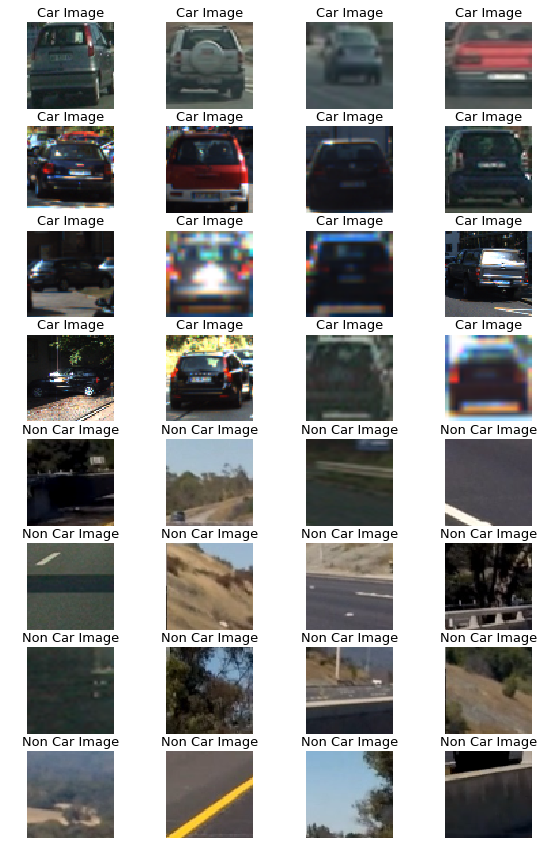

In [3]:
fig, axs = plt.subplots(8,4, figsize=(10, 15))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(16):
    img = cv2.imread(Car_Images[np.random.randint(0,len(Car_Images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Car Image', fontsize = 13)
    axs[i].imshow(img)
    
for i in np.arange(16,32):
    img = cv2.imread(NonCar_Images[np.random.randint(0,len(NonCar_Images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Non Car Image', fontsize = 13)
    axs[i].imshow(img)


## Feature Extraction Functions

In [4]:
#HOG features---------------------------------------------------------------------------------
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Binned color features-----------------------------------------------------------------------  
def bin_spatial(img, size=(32, 32)):
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Color histogram features--------------------------------------------------------------------  
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


## Combine all the above features and extract them from all the images

In [5]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Feature extraction from a single image

In [6]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

## Visualize each Feature

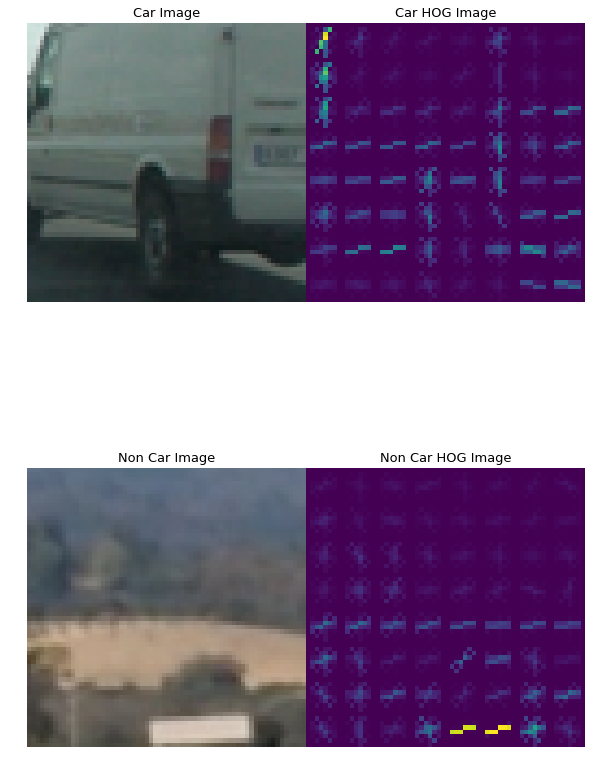

In [7]:
CarImg = cv2.imread(Car_Images[np.random.randint(0,len(Car_Images))])
CarImg = cv2.cvtColor(CarImg,cv2.COLOR_BGR2RGB)

NonCarImg = cv2.imread(NonCar_Images[np.random.randint(0,len(NonCar_Images))])
NonCarImg = cv2.cvtColor(NonCarImg,cv2.COLOR_BGR2RGB)

# Call our function with vis=True to see an image output
CarGray = cv2.cvtColor(CarImg, cv2.COLOR_RGB2GRAY)
CarHOG_features, Car_hog_image = get_hog_features(CarGray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

NonCarGray = cv2.cvtColor(NonCarImg, cv2.COLOR_RGB2GRAY)
NonCarHOG_features, NonCar_hog_image = get_hog_features(NonCarGray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)


fig, axs = plt.subplots(2,2, figsize=(10, 15))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('Car Image', fontsize = 13)
axs[0].imshow(CarImg)

axs[1].axis('off')
axs[1].set_title('Car HOG Image', fontsize = 13)
axs[1].imshow(Car_hog_image)

axs[2].axis('off')
axs[2].set_title('Non Car Image', fontsize = 13)
axs[2].imshow(NonCarImg)

axs[3].axis('off')
axs[3].set_title('Non Car HOG Image', fontsize = 13)
axs[3].imshow(NonCar_hog_image)

## Extract features from all the images and split into Training and Testing sets

In [8]:
# color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 11  # HOG orientations
# pix_per_cell = 16 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
# spatial_size = (32, 32) # Spatial binning dimensions
# hist_bins = 32    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off
# hog_feat = True # HOG features on or off

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off



car_features = extract_features(Car_Images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(NonCar_Images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print(len(X_train), len(X_test), len(y_train), len(y_test))

14208 3552 14208 3552


## Normalize the data

In [9]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


## Choose the Classifier and train it (in this case SVM)

In [10]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t1, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t1 = time.time()

21.78 Seconds to train SVC...
Test Accuracy of SVC =  0.9913


## Sliding Window

In [11]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan - nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan - ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

## Search the Window where the Vehicle is

In [12]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Draw Boxes

In [13]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random':
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


## Search window on a test image

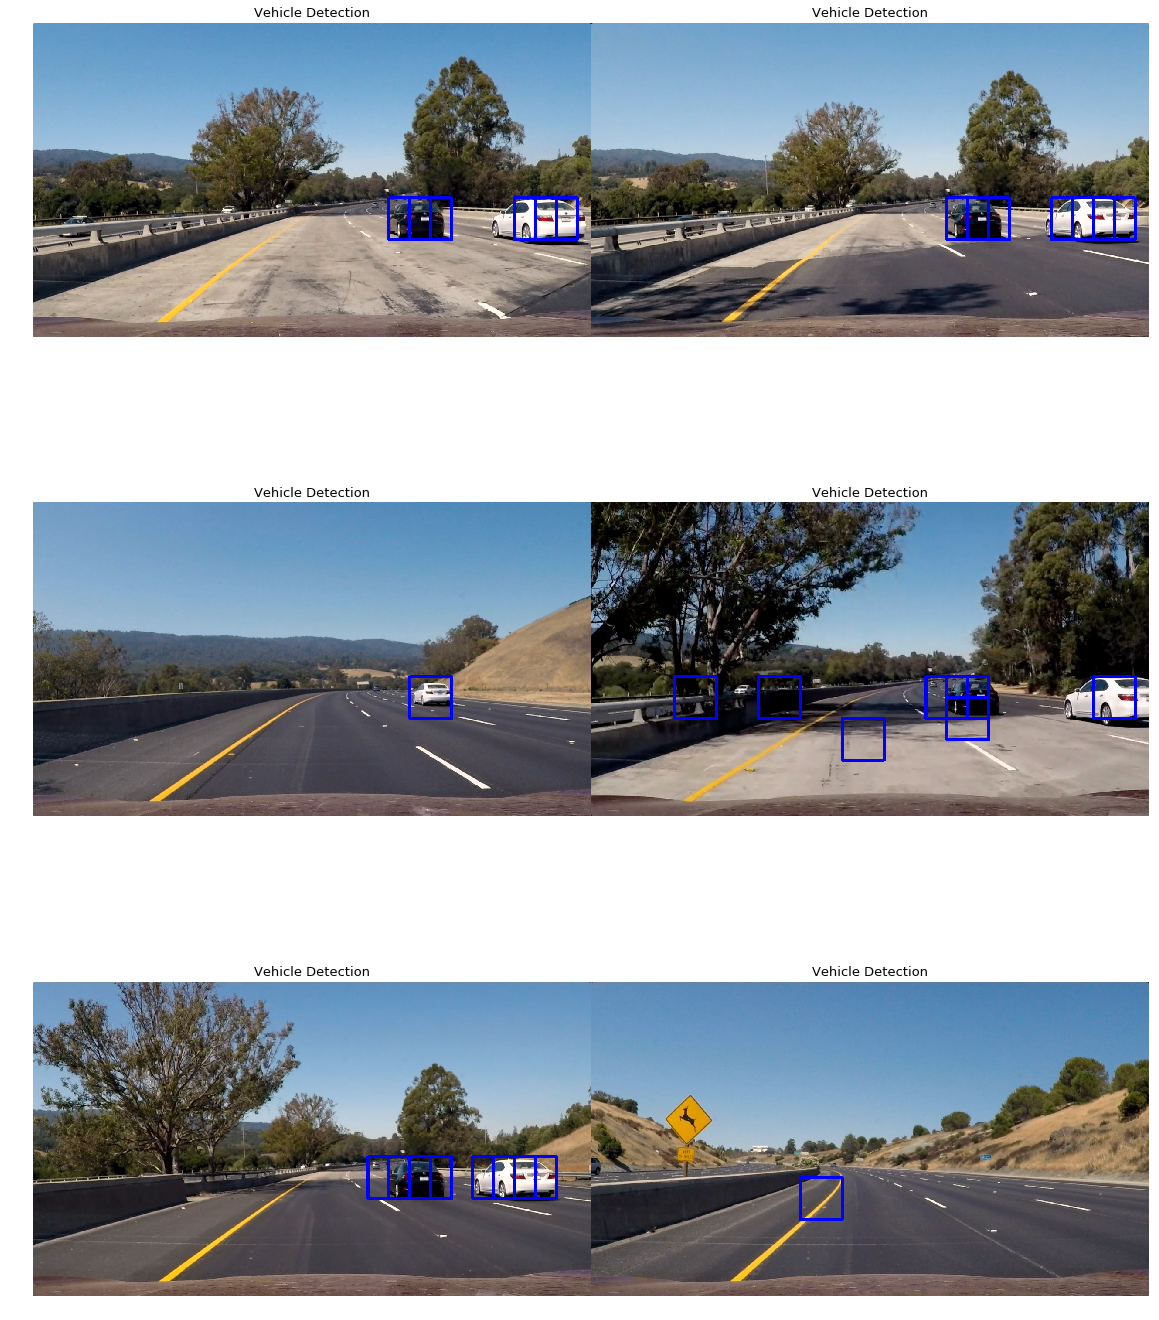

In [14]:
y_start_stop = [400, 656] # Min and Max in y to search in slide_window()

fig, axs = plt.subplots(3,2, figsize=(20, 25))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

TestImage = glob.glob('test_images/*.jpg')

#TestImage = mpimg.imread('test_images/test6.jpg')

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
for i in np.arange(6):
    img = cv2.imread(TestImage[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    draw_image = np.copy(img)
    img = img.astype(np.float32)/255
    windows = slide_window(img, x_start_stop = [None, None], y_start_stop = y_start_stop, 
                    xy_window = (96, 96), xy_overlap = (0.5, 0.5))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space = color_space, 
                        spatial_size = spatial_size, hist_bins = hist_bins, 
                        orient = orient, pix_per_cell = pix_per_cell, 
                        cell_per_block = cell_per_block, 
                        hog_channel = hog_channel, spatial_feat = spatial_feat, 
                        hist_feat = hist_feat, hog_feat = hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color = (0, 0, 255), thick = 6)   
    
    axs[i].axis('off')
    axs[i].set_title('Vehicle Detection', fontsize = 13)
    axs[i].imshow(window_img)


                 
# plt.figure(figsize=(10,10))
# plt.imshow(window_img)


## Hog Sub-sampling Window Search

In [15]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    rectangles = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
     # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)   
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
     # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    
#     print('hist_bins Size:', hist_bins,'\n')
#     print('spatial_size Size:', spatial_size,'\n')
#     print('Image Size:', ch1.shape,'\n')
#     print('pix_per_cell:', pix_per_cell,'\n')
#     print('cell_per_block:', cell_per_block,'\n')
#     print('ch1.shape[1] :', ch1.shape[1] ,'\n')
#     print('nxblocks :', nxblocks ,'\n')
    
    
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    
   # print('nblocks_per_window :', nblocks_per_window ,'\n')
  
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
#     print('nxsteps :', nxsteps ,'\n')
#     print('nysteps :', nysteps ,'\n')
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    #print('hog1:',hog1,'\n')
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            #---------------------------------------------------------------------------------------------------

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop : (ytop+window), xleft : (xleft+window)], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            
            test_prediction = svc.predict(test_features)

                       
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart),(0,0,255),6) 
                rectangles.append(((xbox_left, ytop_draw + ystart),(xbox_left + win_draw,ytop_draw + win_draw + ystart)))
    
    return rectangles

[((16, 448), (80, 512)), ((64, 560), (128, 624)), ((320, 592), (384, 656)), ((336, 576), (400, 640)), ((800, 416), (864, 480)), ((816, 400), (880, 464)), ((816, 416), (880, 480)), ((816, 432), (880, 496)), ((832, 400), (896, 464)), ((832, 416), (896, 480)), ((832, 432), (896, 496)), ((848, 400), (912, 464)), ((848, 416), (912, 480)), ((848, 432), (912, 496)), ((864, 400), (928, 464)), ((864, 416), (928, 480)), ((864, 432), (928, 496)), ((880, 400), (944, 464)), ((880, 416), (944, 480)), ((880, 432), (944, 496)), ((880, 448), (944, 512)), ((1040, 432), (1104, 496)), ((1056, 432), (1120, 496)), ((1072, 448), (1136, 512)), ((1104, 416), (1168, 480)), ((1104, 432), (1168, 496)), ((1104, 448), (1168, 512)), ((1120, 400), (1184, 464)), ((1120, 416), (1184, 480)), ((1120, 432), (1184, 496)), ((1120, 448), (1184, 512)), ((1136, 400), (1200, 464)), ((1136, 432), (1200, 496)), ((1136, 448), (1200, 512)), ((1152, 400), (1216, 464)), ((1152, 448), (1216, 512)), ((1168, 432), (1232, 496)), ((1168, 

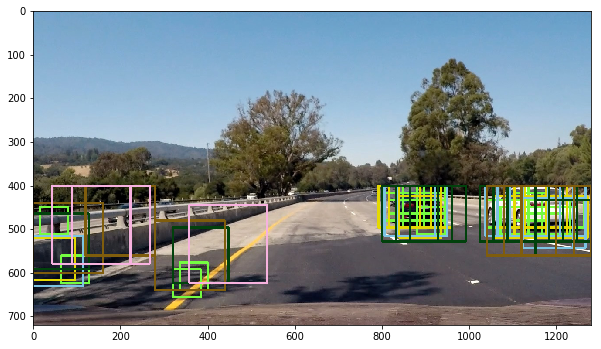

In [16]:
TestImage = mpimg.imread('test_images/test4.jpg')
ystart = 400
ystop = 656
scales = [1.0, 1.5, 1.8, 2.0, 2.5, 2.8]

Rects = []
rects = []
temp = np.copy(TestImage)



for scale in scales:
    rect = find_cars(TestImage, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    test_img_rects = draw_boxes(temp, rect, color='random', thick = 4)
    temp = np.copy(test_img_rects)
    if rect:
        rects.append(rect)
            
Rects = sum(rects, [])
print(Rects,'\n')
plt.figure(figsize=(10,10))
plt.imshow(temp)

## Remove Multiple Detections & False Positives  

In [17]:
bbox_list = Rects
heat = np.zeros_like(TestImage[:,:,0]).astype(np.float)
print(bbox_list)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


[((16, 448), (80, 512)), ((64, 560), (128, 624)), ((320, 592), (384, 656)), ((336, 576), (400, 640)), ((800, 416), (864, 480)), ((816, 400), (880, 464)), ((816, 416), (880, 480)), ((816, 432), (880, 496)), ((832, 400), (896, 464)), ((832, 416), (896, 480)), ((832, 432), (896, 496)), ((848, 400), (912, 464)), ((848, 416), (912, 480)), ((848, 432), (912, 496)), ((864, 400), (928, 464)), ((864, 416), (928, 480)), ((864, 432), (928, 496)), ((880, 400), (944, 464)), ((880, 416), (944, 480)), ((880, 432), (944, 496)), ((880, 448), (944, 512)), ((1040, 432), (1104, 496)), ((1056, 432), (1120, 496)), ((1072, 448), (1136, 512)), ((1104, 416), (1168, 480)), ((1104, 432), (1168, 496)), ((1104, 448), (1168, 512)), ((1120, 400), (1184, 464)), ((1120, 416), (1184, 480)), ((1120, 432), (1184, 496)), ((1120, 448), (1184, 512)), ((1136, 400), (1200, 464)), ((1136, 432), (1200, 496)), ((1136, 448), (1200, 512)), ((1152, 400), (1216, 464)), ((1152, 448), (1216, 512)), ((1168, 432), (1232, 496)), ((1168, 

In [18]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [19]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

(720, 1280)


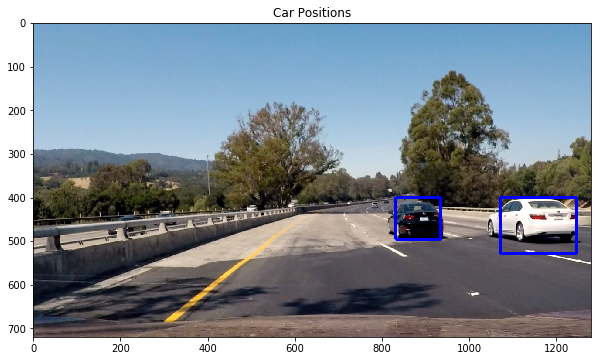

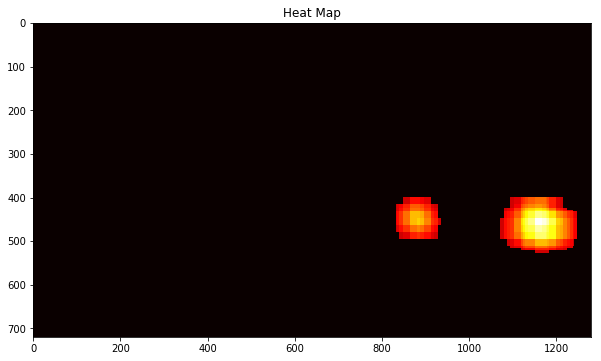

In [20]:
# Add heat to each box in box list
heat = add_heat(heat,bbox_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,9)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
print(heat.shape)
# Find final boxes from heatmap using label function
labels = label(heatmap)
#print(labels[0])

draw_img = draw_labeled_bboxes(np.copy(TestImage), labels)

plt.figure(figsize=(10,10))
#fig = plt.figure()
#plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
#plt.subplot(122)
plt.figure(figsize=(10,10))
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Pipeline

In [21]:
WINDOW_SIZE = 3 # No samples for moving averaging


# #Global Array.......................
HeatArray = np.zeros([720, 1280, WINDOW_SIZE])
n = 0
AvgHeat = np.zeros([720, 1280])
WinFull = 0



def pipeline(TestImage):
    
    global HeatArray
    global n
    global AvgHeat
    global WinFull
    #global FirstHeatmap
    
    Rects = []
    rectangles = []
    temp = np.copy(TestImage)

    
  #---------------YAxis Start/Stop and Scaling---------------------------------------------------------------------  
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(TestImage, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(TestImage, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(TestImage, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(TestImage, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(TestImage, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(TestImage, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(TestImage, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(TestImage, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
  #------------------------------------------------------------------------------------------------------
            
    Rects = sum(rectangles, [])
    
    bbox_list = Rects
    heat = np.zeros_like(TestImage[:,:,0]).astype(np.float)
    #print(bbox_list)
    
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
        
    
    # Apply threshold to help remove false positives
    Heat = heat 
    Heat = apply_threshold(Heat,6)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(Heat, 0, 255)
    
    #average Heat-------------------------------------------------------------
    
    
    if WinFull == 1:
        for m in range(1, WINDOW_SIZE):
            HeatArray[:, :, m-1] = HeatArray[:, :, m]
        
        HeatArray[:,:,WINDOW_SIZE-1] = heatmap
    
    else:
        HeatArray[:,:,n] = heatmap
    
    n = n + 1
    if n == WINDOW_SIZE:
        WinFull = 1
        n = 0
    
    AvgHeat = HeatArray/WINDOW_SIZE
    AvgHeat = AvgHeat.astype(int)

    # Find final boxes from heatmap using label function---------------------------
    #labels = label(heatmap)
    labels = label(AvgHeat)
    
    #print('labels:', labels, '\n')
    draw_img = draw_labeled_bboxes(np.copy(TestImage), labels)
    
    return draw_img
    

In [22]:
white_output = 'project_output.mp4'
clip = VideoFileClip("test_video.mp4")
#clip = VideoFileClip("project_video.mp4")
white_clip = clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


 97%|█████████▋| 38/39 [00:35<00:01,  1.05s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 37.3 s, sys: 152 ms, total: 37.4 s
Wall time: 37.5 s
